In [1]:
from numpy.random import seed, normal, binomial, uniform
from numpy import cov
import statsmodels.formula.api as smf
from pandas import DataFrame
from seaborn import kdeplot

seed(1234)

In [73]:
n = 1000
instrument_impact = 0.7

confounder = binomial(1, 0.3, n)
instrument = binomial(1, 0.5, n)
treatment = (uniform(0, 1, n) <= instrument_impact*instrument + 0.4*confounder).astype(int)
outcome = 30 - 2*treatment + 10 * confounder + normal(0, 2, n)

df = DataFrame({
    'instrument': instrument,
    'treatment': treatment,
    'outcome': outcome
})

In [84]:
smf.ols(formula='outcome ~ treatment', data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     12.57
Date:                Sat, 22 Jul 2023   Prob (F-statistic):           0.000410
Time:                        18:05:34   Log-Likelihood:                -2940.9
No. Observations:                1000   AIC:                             5886.
Df Residuals:                     998   BIC:                             5896.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     31.4823      0.195    161.725      0.000      31.100      31.864
treatment      1.0347      0.292      3.546      0.000       0.462       1.607
==============================================================================
Omnibus:                       71.320   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.234
Skew:                           0.575   Prob(JB):                     2.51e-15
Kurtosis:                       2.460   Cond. No.                         2.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:
outcome_1 = df[df.treatment==1].outcome.mean()
outcome_0 = df[df.treatment==0].outcome.mean()
print(outcome_1 - outcome_0)

1.0347180418009607


In [60]:
cov(instrument, outcome)[0][1]/cov(instrument, treatment)[0][1]

-1.6948613532822632

In [81]:
model = smf.ols(formula='treatment ~ instrument', data=df).fit()
df['treatment_prediction'] = model.predict(df)

smf.ols(formula='outcome ~ treatment_prediction', data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     13.84
Date:                Sat, 22 Jul 2023   Prob (F-statistic):           0.000210
Time:                        17:30:37   Log-Likelihood:                -2940.3
No. Observations:                1000   AIC:                             5885.
Df Residuals:                     998   BIC:                             5894.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               32.6507      0.239    136.487      0.000      32.181      33.120
treatment_prediction    -1.5911      0.428     -3.720      0.000      -2.430      -0.752
==============================================================================
Omnibus:                      111.435   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.778
Skew:                           0.687   Prob(JB):                     5.86e-22
Kurtosis:                       2.323   Cond. No.                         3.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
from linearmodels.iv.model import IV2SLS

IV2SLS.from_formula('outcome ~ 1  + [treatment ~ instrument]',df).fit()

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                outcome   R-squared:                     -0.0677
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0687
No. Observations:                1000   F-statistic:                    12.805
Date:                Sat, Jul 22 2023   P-value (F-stat)                0.0003
Time:                        17:30:30   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      32.651     0.2474     131.96     0.0000      32.166      33.136
treatment     -1.5911     0.4446    -3.5785     0.0003     -2.4626     -0.7196
==============================================================================

Endogenous: treatment
Instruments: instrument
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x133db18d0

In [2]:
def generate_data(instrument_impact, n):
    confounder = binomial(1, 0.3, n)
    instrument = binomial(1, 0.5, n)
    treatment = (uniform(0, 1, n) <= instrument_impact*instrument + 0.4*confounder).astype(int)
    outcome = 30 + instrument_impact*treatment + 10 * confounder + normal(0, 2, n)

    return(DataFrame({
        'instrument': instrument,
        'treatment': treatment,
        'outcome': outcome
    }))

def estimate_impact(df):
    return(cov(df.instrument, df.outcome)[0][1]/cov(df.instrument, df.treatment)[0][1])

In [49]:
sim_n = 1000

instrument_impact_1 = 0.3
estimates_1 = []
for i in range(sim_n):
    df = generate_data(instrument_impact_1, n)
    estimates_1.append(estimate_impact(df))

In [50]:
instrument_impact_2 = 0.1
estimates_2 = []
for i in range(sim_n):
    df = generate_data(instrument_impact_2, n)
    estimates_2.append(estimate_impact(df))

In [51]:
df_plot = DataFrame({
    'estimate': estimates_1 + estimates_2,
    'instrument_impact': [instrument_impact_1]*n + [instrument_impact_2]*n
})

<Axes: xlabel='estimate', ylabel='Density'>

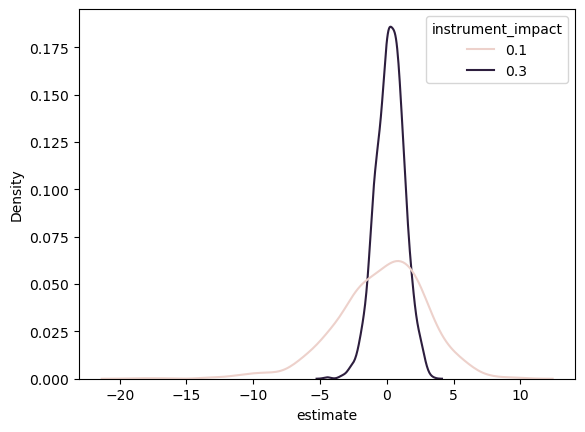

In [52]:
kdeplot(data = df_plot, x='estimate', hue='instrument_impact')

In [44]:
import doubleml as dml
from sklearn.linear_model import LinearRegression, LogisticRegression

n = 10000
df = generate_data(0.5, 1000)

print(estimate_impact(df))
df['x'] = 1

ml_g = LinearRegression()
ml_m = LogisticRegression(penalty=None)
ml_r = LogisticRegression(penalty=None)

obj_dml_data = dml.DoubleMLData(df, y_col='outcome', d_cols='treatment', z_cols='instrument')
dml_iivm_obj = dml.DoubleMLIIVM(obj_dml_data, ml_g, ml_m, ml_r)
dml_iivm_obj.fit().summary


0.9762328562358012


,coef,std err,t,P>|t|,2.5 %,97.5 %
treatment,0.953482,0.585389,1.628802,0.103355,-0.193858,2.100823


In [45]:
import pandas as pd

pd.read_csv("df.csv")
df

,instrument,treatment,outcome,x
0,0,1,39.890097,1
1,0,0,39.313675,1
2,0,0,29.754342,1
3,1,1,41.513042,1
4,0,0,28.625697,1
...,...,...,...,...
995,1,1,41.533379,1
996,0,0,30.372180,1
997,1,0,26.080957,1
998,0,0,30.498223,1


In [46]:
ml_g = LinearRegression()
ml_m = LogisticRegression(penalty=None)
ml_r = LogisticRegression(penalty=None)

obj_dml_data = dml.DoubleMLData(df, y_col='outcome', d_cols='treatment', z_cols='instrument')
dml_iivm_obj = dml.DoubleMLIIVM(obj_dml_data, ml_g, ml_m, ml_r)
dml_iivm_obj.fit().summary


,coef,std err,t,P>|t|,2.5 %,97.5 %
treatment,0.984465,0.58232,1.690592,0.090915,-0.156861,2.125791


In [47]:
cov(df.instrument, df.outcome)[0][1]/cov(df.instrument, df.treatment)[0][1]

0.9762328562358012